In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt 
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import date
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud, STOPWORDS 

In [2]:
# Read chatlog data
chatlog = pd.read_pickle('./data/chatlog.p') 

In [3]:
chatlog

,userId,full_name,message,role,_date,_time
0,2433413723406579,Watsana Kongngoen,สวัสดี,User,2019-11-01,15:23
1,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,15:23
2,2433413723406579,Watsana Kongngoen,"{'type': 'quick_reply', 'list_object': [{'text...",Admin,2019-11-01,15:23
3,2433413723406579,Watsana Kongngoen,สวัสดีครับ,User,2019-11-01,16:15
4,2433413723406579,Watsana Kongngoen,"{'type': 'text', 'text': 'เงินติดล้อสวัสดีครับ'}",Admin,2019-11-01,16:15
...,...,...,...,...,...,...
2298575,1379039449007314,None None,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24,23:56
2298576,1379039449007314,None None,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24,23:57
2298577,1379039449007314,None None,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24,23:58
2298578,1379039449007314,None None,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24,23:59


In [4]:
def check_keywords(txt):
    if "toyotavogo" in txt:
        return 1
    else:
        return 0

In [4]:
# Format time to match with the data
today = date.today()
td = today.strftime("%Y-%m-%d")

In [5]:
one_month = today + relativedelta(months=-1)
td_minus_one_month = one_month.strftime("%Y-%m-%d")

In [6]:
# Clean the chatlog to have only user conversation on specific date
def clean_chatlog(chatlog, start_date:str=td_minus_one_month, end_date:str=td):
    df = chatlog[['userId', 'message', 'role', '_date']] 
    df = df.loc[df.role=='User']
    return df[(df._date >= start_date) & (df._date <= end_date)]

In [7]:
df_new = clean_chatlog(chatlog, start_date='2020-05-01', end_date='2020-05-24')
df_new

,userId,message,role,_date
1892552,2341383209284175,ลองเล่นเรียนรู้,User,2020-05-07
1892599,3550386191670494,จะสอบถามเรื่องจำนำเล่มทะเบียนครับ,User,2020-05-07
1892602,3550386191670494,สินเชื่อทะเบียนรถยนต์2,User,2020-05-07
1892604,3550386191670494,ส่งเรื่องไปแล้วแต่อยากทราบว่าเรื่องผ่านแล้วยัง...,User,2020-05-07
1892606,3550386191670494,สอบถามว่าสินเชื่อผ่านแล้วยังครับ,User,2020-05-07
...,...,...,...,...
2298575,1379039449007314,สาขา วังไผ่ (ชุมพร) ตรงข้ามบิ๊กซี สาขาชุมพร จ้า,User,2020-05-24
2298576,1379039449007314,จริงใจพร้อมให้ความช่วยเหลือ รอสักครู่นะจ๊ะ,User,2020-05-24
2298577,1379039449007314,เอกสารประกอบการยื่นเรื่อง\n1. เล่มทะเบียนรถตัว...,User,2020-05-24
2298578,1379039449007314,รถปลอดภาระแล้วหรืออยู่ระหว่างผ่อนชำระคับ,User,2020-05-24


In [8]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [9]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [8]:
# Utils
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace(',', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [9]:
# Clean undesired text
def clean_text_1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊|คร้า','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คัฟ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [10]:
def filter_words(text):
    text = text.replace('\n', ' ') 
    text = text.replace(',', ' ')
    stop_words = set(thai_stopwords()) 
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False) 
    filtered_text = [] 
    for w in tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
    return filtered_text

In [32]:
stop_words = set(thai_stopwords())

{'เพียงเพราะ', 'คราวนี้', 'หรือยัง', 'มิ', 'อย่างๆ', 'ที่นั้น', 'จัดให้', 'พวกฉัน', 'หากแม้นว่า', 'แท้จริง', 'สั้นๆ', 'พอตัว', 'กันดีไหม', 'นี่แหละ', 'ทั้งตัว', 'มุ่ง', 'เหตุ', 'เก็บ', 'สมัยนี้', 'ตั้งแต่', 'อนึ่ง', 'นํา', 'ราย', 'ใหญ่', 'ขณะเดียวกัน', 'กระผม', 'เพียงพอ', 'ขณะที่', 'จำเป็น', 'เหตุไร', 'นับแต่ที่', 'ส่วนด้อย', 'ช้าๆ', 'เกิน', 'ลง', 'ละ', 'ค่อยไปทาง', 'พอ', 'ที่ใด', 'หมดกัน', 'พอจะ', 'ยังคง', 'พา', 'เช่นกัน', 'เรียบ', 'คุณ', 'มั้ยนะ', 'เมื่อไร', 'ทุกๆ', 'อยู่', 'แต่เดิม', 'แค่ไหน', 'จัดทำ', 'มั้ยนั่น', 'สิ่งใด', 'ก็ได้', 'เฉย', 'เปิดเผย', 'เริ่ม', 'เล็กน้อย', 'คล้าย', 'อื่นๆ', 'ว่า', 'ยก', 'ที่สุด', 'เสียนั่น', 'ทำๆ', 'เพียงไหน', 'อันเนื่องมาจาก', 'ไง', 'ยิ่งใหญ่', 'การ', 'ภายหลัง', 'ใช่ไหม', 'ดั่ง', 'ยืนยาว', 'ทีละ', 'ทำให้', 'ยิ่งขึ้น', 'ข้างบน', 'ในเมื่อ', 'ยังงั้น', 'ช้านาน', 'อันที่จริง', 'คราวหลัง', 'ก็คือ', 'ทุกสิ่ง', 'ที่ละ', 'ที่แท้', 'อย่างหนึ่ง', 'เป็นอัน', 'เฉพาะ', 'วันนั้น', 'แต่ละ', 'หากแม้น', 'ภายภาค', 'ก่อนๆ', 'ตลอดไป', 'ก็ตาม', 'เห็นจะ', 'ณ', 'รือว่า', '

In [11]:
def remove_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [12]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u200B"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [13]:
# Combine
def clean_text_full(df):
    df = df.groupby(['userId'])['message'].apply(','.join).reset_index()
    df['message'] = df['message'].apply(lambda x: clean_text_1(x))
    df['message'] = df['message'].apply(lambda x: remove_emoji(x))
    df['message'] = df['message'].apply(lambda x: remove_digits(x))
    df['message'] = df['message'].apply(lambda x: filter_words(x))
    df['message'] = df['message'].apply(lambda x: " ".join(x))
    return df

In [14]:
df_new_clean = clean_text_full(df_new)
df_new_clean

,userId,message
0,1053638671428956,สไตล์ ชัดเจน ติดต่อ เห
1,1090076504449811,บริษัท ผ่อน ประกัน ผ่อน กี่ งวด ฿ บริษัท ผ่อน ...
2,1103018183155560,รถ วีออส ทำ
3,1107310099393315,
4,1107777509340311,ส วัด ดี สไตล์ ชัดเจน ติดต่อ เห
...,...,...
12353,5473248259359352,httpsscontentxxfbcdnnetvtnjpgnccatncsidbencohc...
12354,5989385281165741,เบ อติ ด สาขา พิมาย แม่ค้า เล่ม ทะเบียน แทน ไห...
12355,632711333520482,ชำระ งวด
12356,839608806163231,เรื่อง สินเชื่อ จำนำ ทะเบียนรถ สินเชื่อ ทะเบีย...


In [51]:
df_new['check'] = df_new.message.apply(lambda x: check_keywords(x))

In [52]:
df_new[df_new['check'] == 1]

,userId,message,role,_date,check


In [15]:
# find top 20 keywords that has the highest TF-IDF average score
def top_20_keywords(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / np.count_nonzero(feat_clean_array,axis=0) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [16]:
def top_20_keywords_new(df):
    vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2) 
    vectorizer.fit(df['message']) 
    feat_clean = vectorizer.transform(df['message']) 
    feat_clean_array = feat_clean.toarray() 
    avg_tfidf = feat_clean_array.sum(axis=0) / len(df['userId']) 
    result_clean = pd.DataFrame() 
    result_clean['word'] = vectorizer.get_feature_names() 
    result_clean['avg_tfidf'] = avg_tfidf 
    result_clean['word'] = result_clean['word'].apply(lambda x: x.replace(" ", ""))
    return result_clean.sort_values('avg_tfidf', ascending=False).head(20) 

In [17]:
df_new_normal = top_20_keywords(df_new_clean)
df_new_normal 

,word,avg_tfidf
0,allnewdmax,1.0
504,คนรับสายเปลี่ยนคน,1.0
3693,รถผ่อนจำนำ,1.0
3720,รถผ่อนโอนย้าย,1.0
3728,รถฟอร์ดเฟียสต้า,1.0
3812,รถรีโว,1.0
3816,รถรุ่นจำนำ,1.0
5900,เรื่องไฟแนนซ์รถ,1.0
5887,เรื่องสมัครงานสาขา,1.0
534,คิวอาโค้ต,1.0


In [17]:
df_new_new = top_20_keywords_new(df_new_clean)
df_new_new 

,word,avg_tfidf
2599,ติดต่อเหs,0.021096
8626,เบี้ยประกันรถคัน,0.015367
5530,รถคันโปรด,0.015362
8269,เงินติดล้อ,0.011674
7454,สินเชื่อทะเบียนรถจักรยานยนต์,0.010759
8339,เงื่อนไขสินเชื่อรถจักรยานยนต์,0.009243
6211,รายละเอียดประกันรถยนต์,0.008244
5769,รถจักรยานยนต์ติดต่อเห,0.007963
7520,สินเชื่อรถจักรยานยนต์ติดต่อ,0.007470
5788,รถจักรยานยนต์เงื่อนไขสินเชื่อ,0.007039


In [18]:
df_new_new.to_excel('./excel/topwords_2020-05.xlsx')

In [30]:
doc = "In the-state-of-art of the NLP field, Embedding is the \
success way to resolve text related problem and outperform \
Bag of Words ( BoW ). Indeed, BoW introduced limitations \
large feature dimension, sparse representation etc."
count_vec = CountVectorizer()
count_occurs = count_vec.fit_transform([doc])
count_occur_df = pd.DataFrame(
    (count, word) for word, count in
     zip(count_occurs.toarray().tolist()[0], 
    count_vec.get_feature_names()))
count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
count_occur_df.head()

,Word,Count
16,of,3
26,the,3
3,bow,2
0,and,1
28,way,1


In [37]:
corpus = df_new_clean['message']

0                                              วีออส ใรคั
1                                   ปผม วีโก้ แชมป์ ประตู
2                                                  ออ นิว
3       กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...
4                                                        
                              ...                        
2139                      isuzudmax sx สุรินทร์ ตรีทศ กุล
2140                                   มอ ไซ ผ่อน กู้ ไหม
2141                                         อีซูซุ d max
2142                ผม รายละเอียด อัตราดอกเบี้ย รถ มอไซค์
2143    รายละเอียด ประกัน รถยนต์ ข้อมูล ประกัน เริ่มต้...
Name: message, Length: 2144, dtype: object

In [50]:
count_vectorizer = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)

In [51]:
count_vectorizer.fit(corpus)

CountVectorizer(min_df=2, ngram_range=(3, 3), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1c9805560>)

In [52]:
feat_count = count_vectorizer.transform(corpus)

In [53]:
feat_count_array = feat_count.toarray()

In [54]:
count_occurs_df = pd.DataFrame()

In [56]:
count_occur_df['word'] = count_vectorizer.get_feature_names()
count_occur_df['occurences'] = feat_count_array.sum(axis=0)

ValueError: Length of values does not match length of index

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
def count_words_use(df):
    count_vec = CountVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(3,3), min_df=2)
    count_occurs = count_vec.fit_transform(df['message'])
    count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))
    count_occur_df.columns = ['Word', 'Count']
    return count_occur_df.sort_values('Count', ascending=False, inplace=True)

In [35]:
df_new_count = count_words_use(df_new_clean)
print(df_new_count)

None


In [19]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return (" ".join(words_to_array))

In [20]:
text = gen_text_for_wordcloud(df_new_new)
print(text)

ติดต่อเหs เบี้ยประกันรถคัน รถคันโปรด เงินติดล้อ สินเชื่อทะเบียนรถจักรยานยนต์ เงื่อนไขสินเชื่อรถจักรยานยนต์ รายละเอียดประกันรถยนต์ รถจักรยานยนต์ติดต่อเห สินเชื่อรถจักรยานยนต์ติดต่อ รถจักรยานยนต์เงื่อนไขสินเชื่อ รายละเอียดสินเชื่อสินเชื่อ สไตล์ชัดเจนติดต่อ ชัดเจนติดต่อเห สไตล์ชัดเจนรายละเอียด คันโปรดdljingjai รถยนต์เบี้ยประกันรถ ทะเบียนรถจักรยานยนต์เงื่อนไข ประกันรถยนต์เบี้ยประกัน รถยนต์ติดต่อเห เงื่อนไขสินเชื่อรถยนต์


In [21]:
def gen_word_cloud(text):
    path = './font/THSarabunNew.ttf'
    wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig('./WordCloud/keyword_2020-05.png')

#     plt.savefig('./WordCloud/keyword_{}.png'.format(td))
    

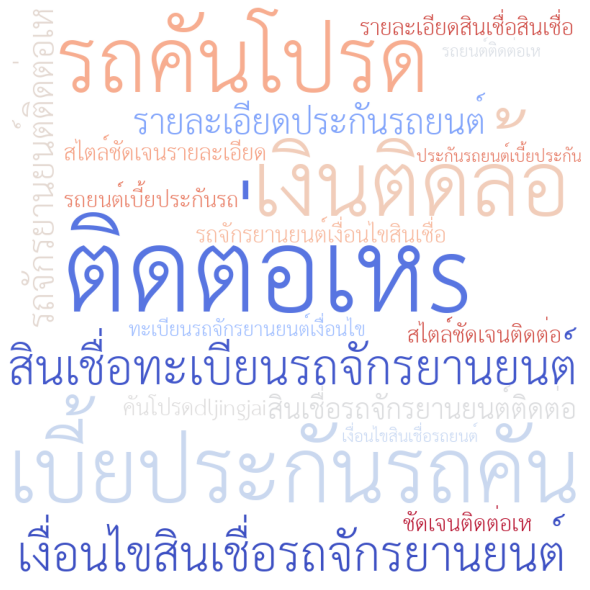

In [22]:
gen_word_cloud(text)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [20]:
submit_to_agent = pd.read_pickle('./data/submit_to_agent.p') 

In [21]:
df_sa = submit_to_agent.loc[submit_to_agent.reason=='not_response'].reset_index()

In [22]:
df_sa_new = df_sa.groupby(['userId'])['message'].apply(','.join).reset_index()

In [24]:
df_sa_new = clean_text_full(df_sa_new)